In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from points_3blocks.utils import *
import matplotlib.pyplot as plt
from collections import Counter
import os

2023-06-16 02:04:24.819885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 02:04:29.704697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
folder_path = '/home/miglou/catkin_ws/src/MRSI_Thesis_Action_Anticipation/data/points'

x = []
y = []

objects = {"ball":0, "cube":1, "bottle":2, "phone":3, "plier":4, "screwdriver":5, "wood":6}

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    # Create the absolute path to the file
    file_path = os.path.join(folder_path, filename)

    # Check if the file path is a file (not a directory)
    if os.path.isfile(file_path):
        
        f = open(file_path, "r")

        for line in f.readlines():
            ps = [[aux for aux in p[1:-2].split(" ") if len(aux)>0] for p in line.split(",")]
            x.append([[float(p[0]), float(p[1]), float(p[2])] for p in ps])
            y.append(objects[filename.split("_")[0]])

        f.close()

# f = open("12_06_2023_14_30_18.csv", "r")

# for line in f.readlines():
#     ps = [[aux for aux in p[1:-2].split(" ") if len(aux)>0] for p in line.split(",")]
#     x.append([[float(p[0]), float(p[1]), float(p[2])] for p in ps])
#     y.append(1)

# f.close()

# f = open("12_06_2023_15_14_35.csv", "r")

# for line in f.readlines():
#     ps = [[aux for aux in p[1:-2].split(" ") if len(aux)>0] for p in line.split(",")]
#     x.append([[float(p[0]), float(p[1]), float(p[2])] for p in ps])
#     y.append(2)

# f.close()

x = np.array(x)
#x = x[:,:,0:2]
y = np.array(y)

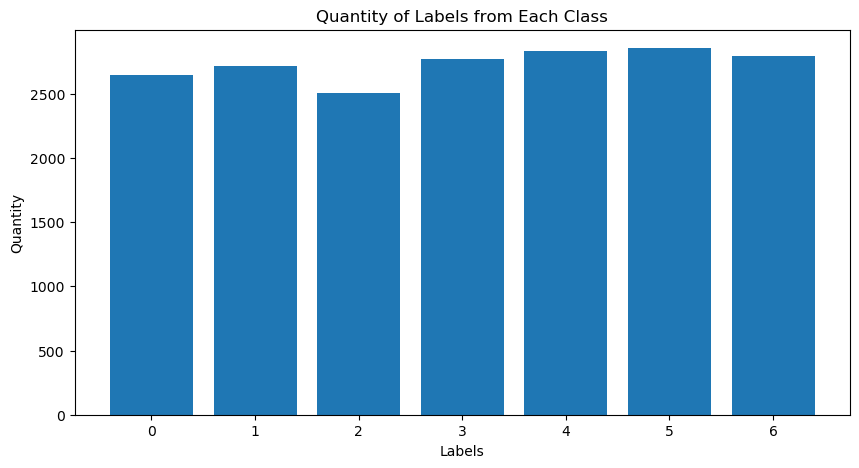

In [3]:
draw_bar_chart(y)

[0 1 2 3 4 5 6]
7


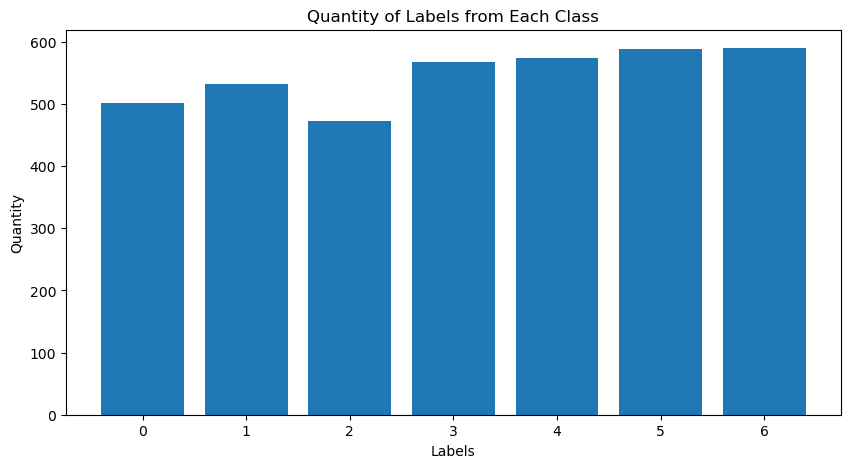

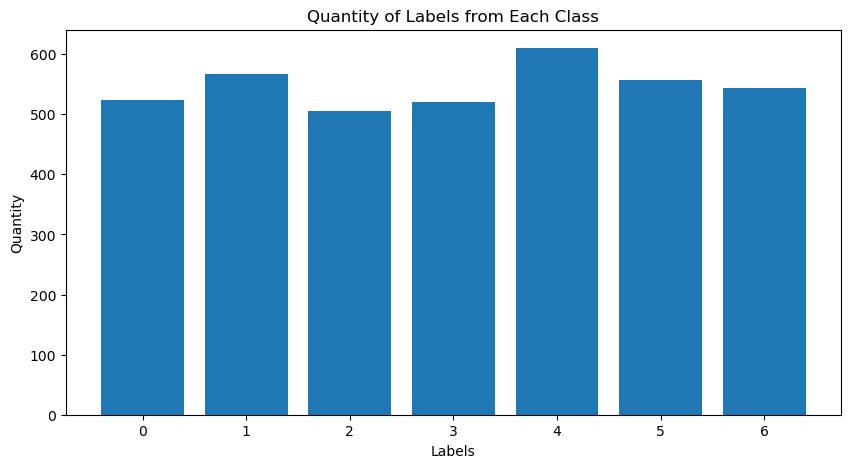

In [4]:
print(np.unique(y))

n_classes = len(np.unique(y))

print(n_classes)

x_train, y_train, x_val, y_val, x_test, y_test = split_and_shuffle(x, y, balanced=False)

draw_bar_chart(y_val)
draw_bar_chart(y_test)

In [5]:
def fc_model(dropout=0.2):
   # Create a `Sequential` model and add a Dense layer as the first layer.
   model = tf.keras.models.Sequential()
   #model.add(tf.keras.Input(shape=(21,3)))
   model.add(tf.keras.layers.Conv1D(32, 2, activation='relu', input_shape=(21,3)))
   model.add(tf.keras.layers.MaxPooling1D(2,1))
   model.add(tf.keras.layers.Flatten())
   model.add(tf.keras.layers.Dropout(dropout))
   model.add(tf.keras.layers.Dense(16, activation='relu'))
   model.add(tf.keras.layers.Dense(7, activation="softmax"))
   return model

In [6]:
input_shape = x.shape[1:]

model = fc_model()

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["sparse_categorical_accuracy"]
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

results = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs=10000,
    batch_size=16,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

2023-06-16 02:04:46.714833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-16 02:04:46.782248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-16 02:04:46.783015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            224       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 608)               0         
                                                                 
 dropout (Dropout)           (None, 608)               0         
                                                                 
 dense (Dense)               (None, 16)                9744      
                                                                 
 dense_1 (Dense)             (None, 7)                 119       
                                                        

2023-06-16 02:04:59.047768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-06-16 02:05:00.037155: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f59cc010e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-16 02:05:00.037213: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2023-06-16 02:05:00.056248: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-16 02:05:00.292600: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 [==============================] - 9s 6ms/step - loss: 1.8262 - sparse_categorical_accuracy: 0.2554 - val_loss: 1.7010 - val_sparse_categorical_accuracy: 0.3442
Epoch 2/10000
718/718 [==============================] - 4s 6ms/step - loss: 1.6466 - sparse_categorical_accuracy: 0.3608 - val_loss: 1.5739 - val_sparse_categorical_accuracy: 0.3871
Epoch 3/10000
718/718 [==============================] - 4s 6ms/step - loss: 1.5383 - sparse_categorical_accuracy: 0.4061 - val_loss: 1.4686 - val_sparse_categorical_accuracy: 0.4386
Epoch 4/10000
718/718 [==============================] - 4s 5ms/step - loss: 1.4559 - sparse_categorical_accuracy: 0.4418 - val_loss: 1.4034 - val_sparse_categorical_accuracy: 0.4733
Epoch 5/10000
718/718 [==============================] - 4s 6ms/step - loss: 1.3928 - sparse_categorical_accuracy: 0.4732 - val_loss: 1.3438 - val_sparse_categorical_accuracy: 0.5024
Epoch 6/10000
718/718 [==============================] - 4s 6ms/step - loss: 1.3486 - sparse_catego

[0.8188046813011169, 0.7287692427635193]

In [7]:
# maior early stopping, dropout, matriz de confusao, alterar batch size, alterar kernel size, transformers

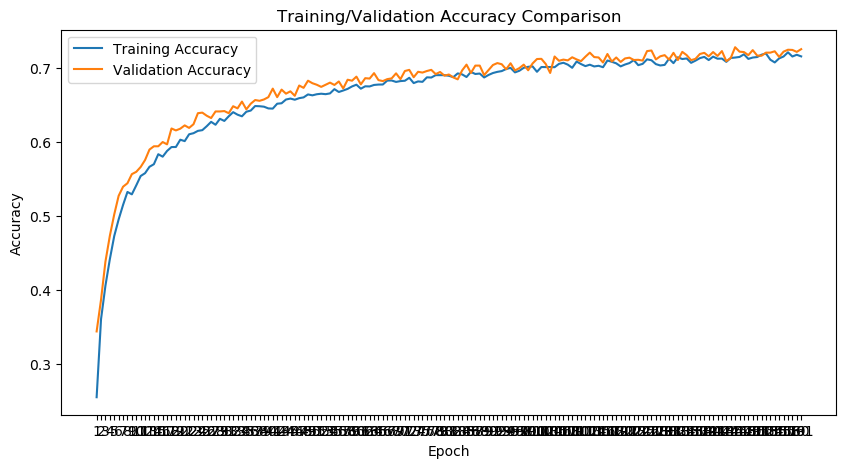

In [8]:
plot_accuracy_comparison([results.history["sparse_categorical_accuracy"], results.history["val_sparse_categorical_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

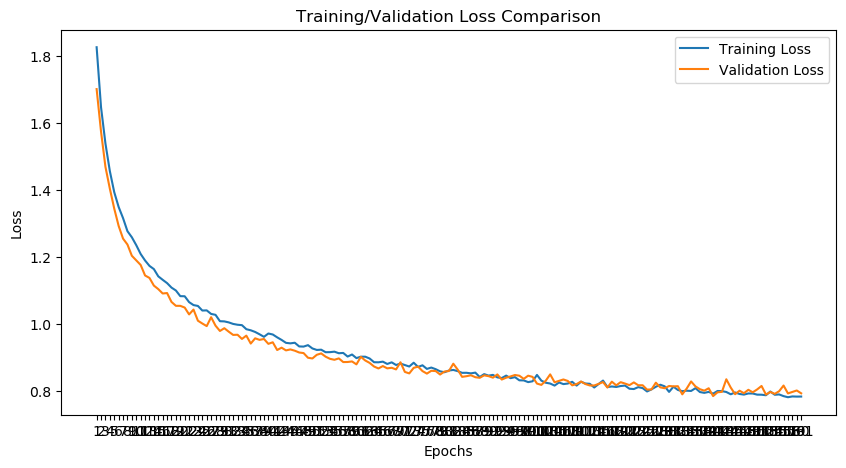

In [9]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

120/120 [==============================] - 0s 2ms/step


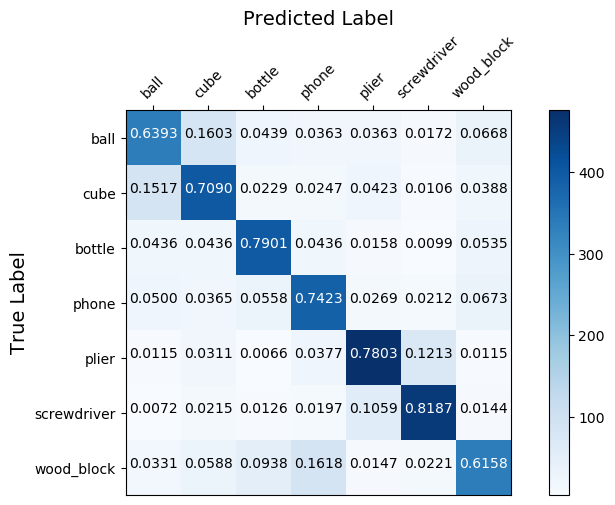

In [17]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
plot_confusion_matrix(y_test, y_pred, ["ball", "cube", "bottle", "phone", "plier", "screwdriver", "wood_block"])

In [11]:
# dropouts=[0.1 * _ for _ in range(6)]
# acc = []
# loss = []

# for d in dropouts:
#     model = fc_model(dropout=d)

#     model.compile(
#         loss="sparse_categorical_crossentropy",
#         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#         metrics=["sparse_categorical_accuracy"]
#     )

#     callbacks = [keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)]

#     results = model.fit(
#         x_train,
#         y_train,
#         validation_data=(x_val,y_val),
#         #validation_split=0.2,
#         epochs=100,
#         batch_size=16,
#         callbacks=callbacks,
#     )

#     acc.append(results.history["val_sparse_categorical_accuracy"])
#     loss.append(results.history["val_loss"])

In [12]:
# plot_accuracy_comparison(acc, "Dropout Comparison (Validation Accuracy)", dropouts)


In [13]:
# plot_loss_comparison(loss, "Dropout Comparison (Validation Loss)", dropouts)

In [14]:
# #a = np.array([0,1,0,0,1,0,0,1,0,0])
# #a = np.array([1,1,0,1,1,0,1,1,0,1])
# #a = np.array([2,2,0,2,2,1,2,2,3,2])
# a = np.array([7,7,0,7,7,3,7,7,6,7])

# a = a.reshape((1, a.shape[0],1))

# print(a.shape)

# model.predict(a)

In [15]:
# model.save('../models/points_conv_1d')

In [16]:
#model = tf.keras.models.load_model('../models/transformer_numbers')